In [ ]:
from cpp_bag.model import BagPooling
from cpp_bag import data
from pathlib import Path
import torch

In [ ]:
DST = Path("data")
MARK = "0"
SPLIT_JSON = DST / f"split{MARK}.json"
WITH_MK = True

In [ ]:
all_cells = data.load_cells()
dataset = data.CustomImageDataset(
    data.FEAT_DIR,
    data.LABEL_DIR,
    bag_size=256,
    cell_threshold=300,
    with_MK=WITH_MK,
    all_cells=all_cells,
)
size = len(dataset)
print("size:", size)

In [ ]:
import json

with open("data/split.json", "r") as f:
        cache = json.load(f)
        val_indices = cache["val"]
        train_indices = cache["train"]
val_set = data.Subset(dataset, val_indices)
train_set = data.Subset(dataset, train_indices)
in_dim = 256
mp = "pool-1648142022566_MK.pth"
model = BagPooling.from_checkpoint(mp, in_dim=in_dim)

In [ ]:
pooling = model.pooling

hopfield_core_forward -> need_weights

attn_output, attn_output_weights, attn_matrix = hopfield_attn(query, key, value)

    - attn_output: :math:`(L, N, E)` where L is the target sequence length, N is the batch size,
              E is the embedding dimension.
    - attn_output_weights: :math:`(N, L, S)` where N is the batch size,
      L is the target sequence length, S is the source sequence length.
    - attn_raw: :math:``(N, num_heads, L, S)`, where N is the batch size,
      L is the target sequence length, S is the source sequence length.

In [ ]:
val_cells = val_set.dataset.cells

In [ ]:
len(val_cells[0])

In [ ]:
from sklearn.preprocessing import minmax_scale

In [ ]:
def att_weight(dataset, index):
    feature, label, sample_cells = dataset.example_samples(index)    
    input_ = feature.unsqueeze(dim=0)
    attn_raw = pooling.get_association_matrix(input_)
    num_heads = attn_raw.size()[1]
    # average attention weights over heads
    attn_output_weights = attn_raw.sum(dim=1) / num_heads
    
    return attn_output_weights.squeeze()[:len(sample_cells)].numpy(), sample_cells, label

In [ ]:
attn_output_weights,  sample_cells, label = att_weight(val_set.dataset, 0)

In [ ]:
attn_output_weights[1]

In [ ]:
import pandas as pd
import numpy as np

In [164]:
attn_output_weights.min()

0.0011252109

In [157]:
_, bins = pd.qcut(attn_output_weights, 10, retbins=True)

In [163]:
bins

array([0.00112521, 0.00194627, 0.00244211, 0.00281031, 0.00310898,
       0.00367559, 0.00399887, 0.00440654, 0.00493315, 0.00572305,
       0.01793513])

In [193]:
def bin_str(bins):
    out = []
    for idx, cut in enumerate(bins[:-1]):
        out.append(f"{cut:.4f}-{bins[idx+1]:.4f}")
    return out[::-1]

In [194]:
bin_strs = bin_str(bins)
bin_strs

['0.0057-0.0179',
 '0.0049-0.0057',
 '0.0044-0.0049',
 '0.0040-0.0044',
 '0.0037-0.0040',
 '0.0031-0.0037',
 '0.0028-0.0031',
 '0.0024-0.0028',
 '0.0019-0.0024',
 '0.0011-0.0019']

In [69]:
ranks = np.digitize(attn_output_weights, bins, right=True)

In [70]:
from collections import defaultdict
rank_map = defaultdict(list)
for idx, rank in enumerate(ranks):
    rank_map[rank].append(idx)

In [75]:
for rank in range(10, 0, -1):
    locs = rank_map[rank]
    locs.sort(key=lambda x:attn_output_weights[x], reverse=True)
    print(bins[rank-1], locs)

0.005723048700019717 [62, 17, 213, 11, 19, 178, 38, 44, 40, 55, 26, 0, 70, 22, 163, 251, 16, 190, 202, 46, 76, 177, 39, 43, 65, 20]
0.004933149553835392 [172, 60, 198, 218, 67, 113, 75, 36, 49, 145, 252, 78, 156, 186, 61, 195, 24, 34, 231, 103, 37, 219, 147, 6, 196]
0.004406540887430312 [8, 255, 117, 223, 5, 142, 66, 74, 180, 80, 53, 157, 168, 110, 13, 217, 230, 25, 81, 33, 134, 174, 98, 68, 2, 136]
0.003998871427029371 [56, 42, 148, 192, 118, 189, 209, 112, 4, 161, 41, 249, 184, 90, 210, 50, 200, 23, 89, 173, 254, 63, 205, 187, 28]
0.0036755946930497885 [95, 21, 232, 73, 116, 7, 12, 175, 126, 253, 244, 188, 141, 214, 216, 88, 114, 206, 153, 108, 208, 228, 120, 138, 45, 212]
0.0031089833937585354 [71, 151, 106, 169, 159, 79, 35, 91, 105, 121, 201, 215, 207, 14, 179, 221, 183, 82, 154, 197, 239, 123, 83, 220, 119]
0.00281030556652695 [176, 31, 155, 84, 182, 194, 94, 111, 143, 204, 93, 165, 15, 18, 96, 238, 237, 140, 97, 203, 101, 137, 233, 185, 29, 225]
0.0024421149864792824 [224, 167, 

In [82]:
import plotly.express as px

CELL_TYPES: list[str] = [
    "Neutrophil",
    "Metamyelocyte",
    "Myelocyte",
    "Promyelocyte",
    "Blast",
    "Erythroblast",
    "Megakaryocyte_nucleus",
    "Lymphocyte",
    "Monocyte",
    "Plasma_cell",
    "Eosinophil",
    "Basophil",
    "Histiocyte",
    "Mast_cell",
]

def mk_color_map(cell_types):
    colors = px.colors.qualitative.Alphabet
    color_map = {t: colors[i % len(colors)] for i, t in enumerate(cell_types)}
    return color_map

COLOR_MAP = mk_color_map(CELL_TYPES)

In [125]:
from PIL import Image, ImageOps, ImageDraw, ImageFont

In [144]:
rank_font = ImageFont.truetype("arial.ttf", 24)
legend_font = ImageFont.truetype("arial.ttf", 18)

In [211]:
rank_font_size = 24
att_font_size = 18
rank_font = ImageFont.truetype("arial.ttf", rank_font_size)
att_font = ImageFont.truetype("arial.ttf", att_font_size)
legend_font = ImageFont.truetype("arial.ttf", 18)
legend_loc = "bottom"
cell_w = 96
padding = 20
left_text_w = 135
text_padding = 4
legend_dot_size = 20
bottom_legend_h = legend_dot_size + 36
legend_gap = 36
legend_right_w = 250
cell_size = cell_w + padding
# canvas_w = cell_size * max(len(locs) for locs in rank_map.values()) + left_text_w
# canvas_h = cell_size * 10 + bottom_legend_h
canvas_w = cell_size * max(len(locs) for locs in rank_map.values()) + left_text_w + legend_right_w
canvas_h = cell_size * 10
canvas = Image.new("RGB", (canvas_w, canvas_h), color=(255, 255, 255))
slide_name = sample_cells[0].name.split(".")[0]
for row_idx, rank in enumerate( range(10, 0, -1)):
    locs = rank_map[rank]
    locs.sort(key=lambda x:attn_output_weights[x], reverse=True)
    for col_idx, loc in enumerate(locs):
        cell = sample_cells[loc]
        cell_name = cell.name
        color = COLOR_MAP[cell.label]
        cell_img =img_loader( f"{slide_name}/{cell_name}.jpg")
        cell_img = ImageOps.fit(cell_img, (cell_w, cell_w), method=Image.ANTIALIAS)
        cell_img = ImageOps.expand(cell_img,border=8,fill=color)
        canvas.paste(cell_img, (col_idx * cell_size + left_text_w,  row_idx * cell_size, ))

for row_idx, rank in enumerate( range(1, 11, 1)):
    d = ImageDraw.Draw(canvas)
    d.text((text_padding, row_idx * cell_size), str(rank), fill=(0, 0, 0), font=rank_font)
    d.text((text_padding, row_idx * cell_size + rank_font_size + 4), bin_strs[row_idx], fill=(0, 0, 0), font=att_font)
# add legend dots to the bottom
# start = text_padding
# for idx, label in enumerate(CELL_TYPES):
#     color = COLOR_MAP[label]
#     d = ImageDraw.Draw(canvas)
#     dot_place = (start, canvas_h - bottom_legend_h, start + legend_dot_size, canvas_h - bottom_legend_h + legend_dot_size)
#     d.rectangle(dot_place, fill=color)        
#     d.text((start, canvas_h - bottom_legend_h + legend_dot_size + text_padding), label, fill=(0, 0, 0), font=legend_font)
#     start = start + legend_dot_size + legend_gap
start_w = canvas_w - legend_right_w + text_padding * 4
start_h = text_padding
for idx, label in enumerate(CELL_TYPES):
    color = COLOR_MAP[label]
    d = ImageDraw.Draw(canvas)
    dot_place = (start_w, start_h, start_w + legend_dot_size, start_h + legend_dot_size)
    d.rectangle(dot_place, fill=color)        
    d.text((start_w + legend_dot_size + text_padding, start_h), label, fill=(0, 0, 0), font=legend_font)
    start_h += legend_gap

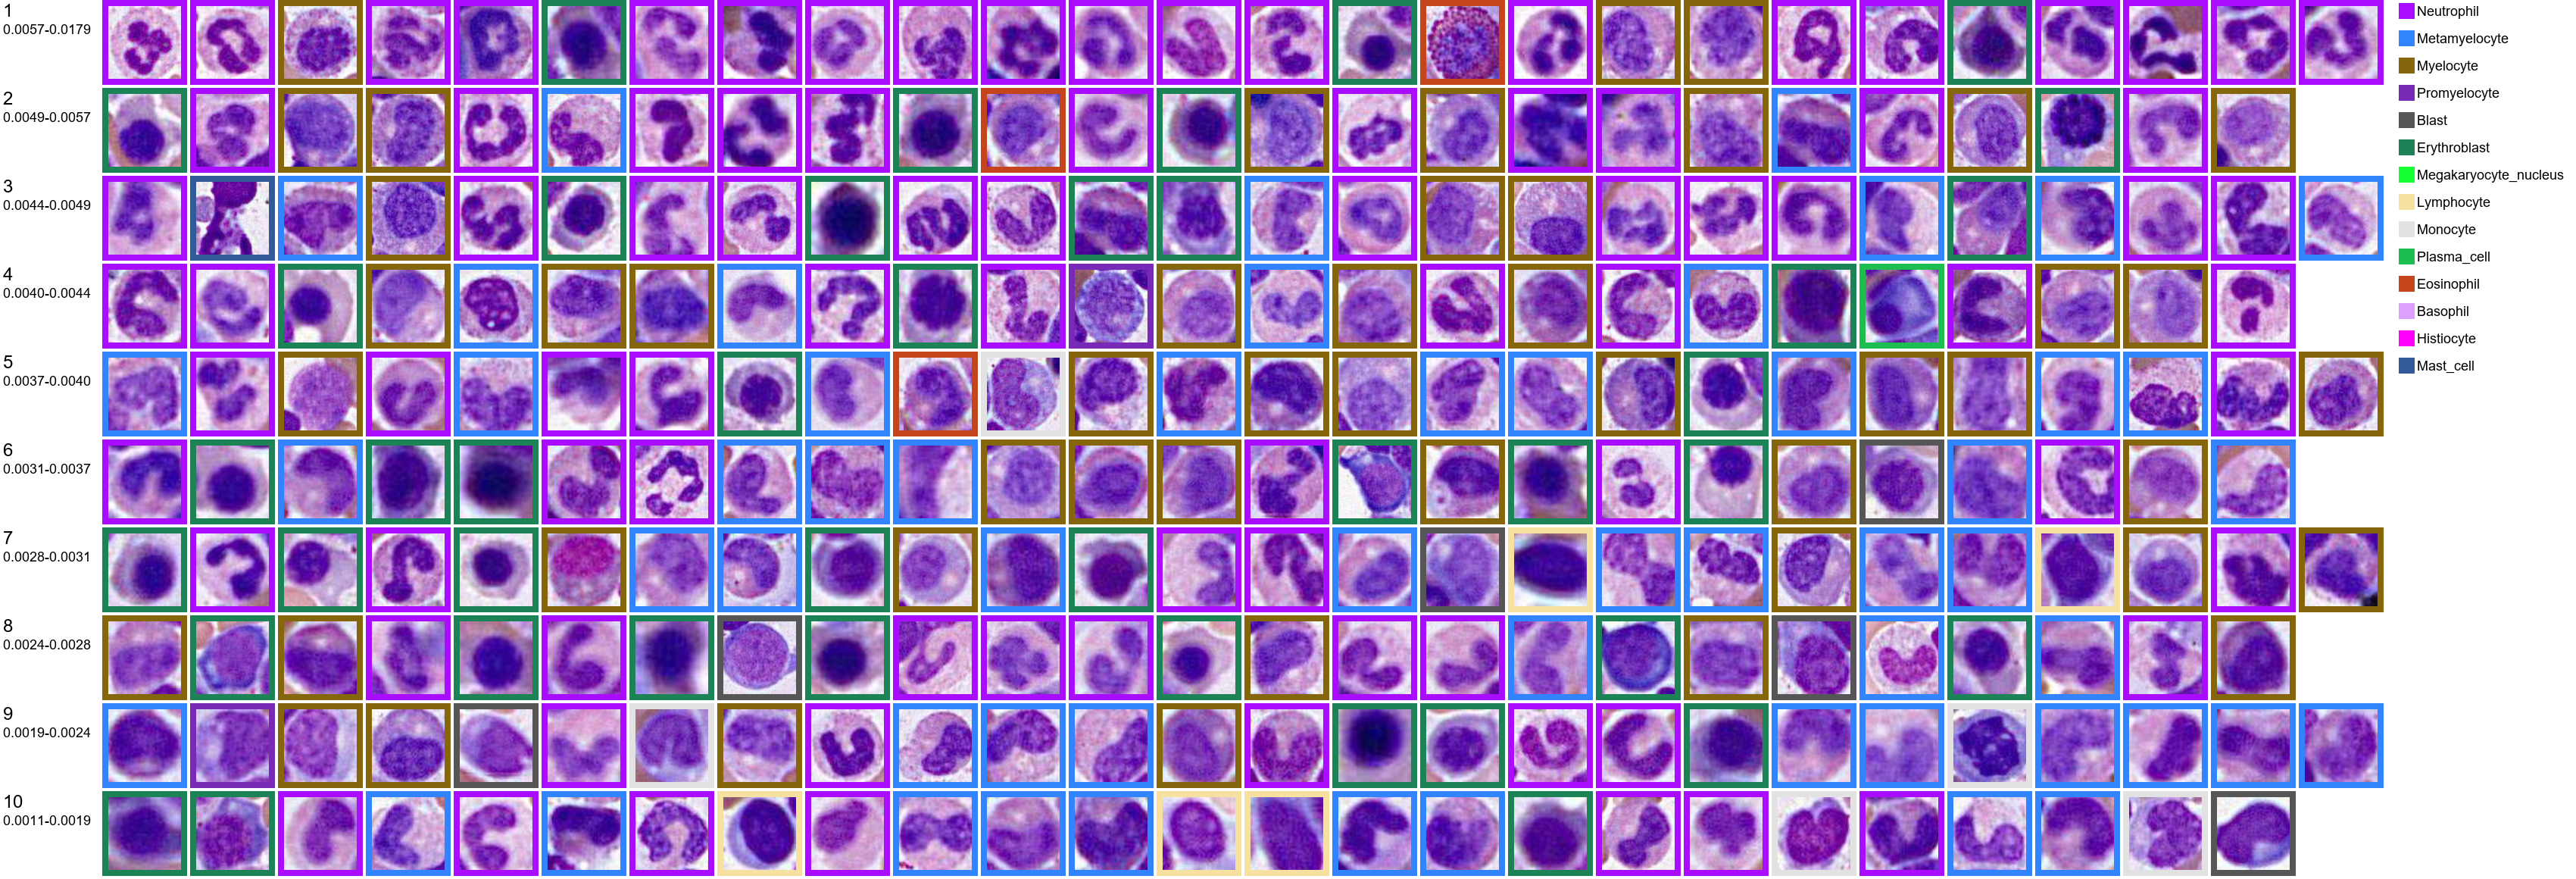

In [212]:
canvas

In [ ]:
len(locs)

In [ ]:
attn_output_weights[62]

In [ ]:
attn_output_weights[0]

In [ ]:
import umap
import pandas as pd
import plotly.express as px

reducer = umap.UMAP()

In [ ]:
for idx in val_indices:
    attn_output_weights,  sample_cells, label = att_weight(val_set.dataset, idx)
    if label != "acute leukemia":
        continue
    feature = [cell.feature for cell in sample_cells]
    embedding = reducer.fit_transform(feature)
    df = pd.DataFrame(embedding)
    df.columns = ["D1", "D2"]
    df["cellType"] =  [cell.label for cell in sample_cells]
    df["weight"] = minmax_scale(attn_output_weights, (0, 1))
    df["size"] = minmax_scale(attn_output_weights, (0.1, 1))
    df["name"] = [cell.name for cell in sample_cells]
    break

In [ ]:
import zipfile

zip_ref = zipfile.ZipFile(Path("D:/DATA/cbp_cell_images.zip"), "r")

In [77]:
from PIL import Image
img_loader = lambda x: Image.open(zip_ref.open(x))


In [ ]:
val_set.dataset.le.classes_

In [ ]:
TEMPLATE = "plotly_white"
FONT = "Arial"

In [ ]:
from PIL import Image, ImageOps

In [ ]:
row["name"]

In [ ]:
import plotly.graph_objects as go


In [ ]:
fig = go.Figure()
fig.add_trace(
            go.Scatter(
                mode='markers',
                x=df["D1"],
                y=df["D2"],
                marker=dict(
                    opacity=0,
                ),
                showlegend=False
            )
        )
slide_name = df.iloc[0]["name"].split(".")[0]
for i, row in df.iterrows():
    weight = row["weight"]
    size = row["size"]
    cell_img =img_loader( f"{slide_name}/{row['name']}.jpg")
    color = get_continuous_color(plotly.colors.PLOTLY_SCALES["RdBu"], weight)
    cell_img = ImageOps.expand(cell_img,border=6,fill=color)
    fig.add_layout_image(
        dict(
            source=cell_img,
            xref="x",
            yref="y",
            xanchor="center",
            yanchor="middle",
            x=row["D1"],
            y=row["D2"],
            sizex=0.35,
            sizey=0.35,
            sizing="contain",
            opacity=size,
            layer="above"
        )
    )
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_layout(
    template=TEMPLATE,
    font_family=FONT,
    legend=dict(
        orientation="h",
    ),
    width=940,
    height=600,
    )

In [ ]:
import plotly.colors

def get_continuous_color(colorscale, intermed):
    """
    Plotly continuous colorscales assign colors to the range [0, 1]. This function computes the intermediate
    color for any value in that range.

    Plotly doesn't make the colorscales directly accessible in a common format.
    Some are ready to use:
    
        colorscale = plotly.colors.PLOTLY_SCALES["Greens"]

    Others are just swatches that need to be constructed into a colorscale:

        viridis_colors, scale = plotly.colors.convert_colors_to_same_type(plotly.colors.sequential.Viridis)
        colorscale = plotly.colors.make_colorscale(viridis_colors, scale=scale)

    :param colorscale: A plotly continuous colorscale defined with RGB string colors.
    :param intermed: value in the range [0, 1]
    :return: color in rgb string format
    :rtype: str
    """
    if len(colorscale) < 1:
        raise ValueError("colorscale must have at least one color")

    if intermed <= 0 or len(colorscale) == 1:
        return colorscale[0][1]
    if intermed >= 1:
        return colorscale[-1][1]

    for cutoff, color in colorscale:
        if intermed > cutoff:
            low_cutoff, low_color = cutoff, color
        else:
            high_cutoff, high_color = cutoff, color
            break

    # noinspection PyUnboundLocalVariable
    color_str = plotly.colors.find_intermediate_color(
        lowcolor=low_color, highcolor=high_color,
        intermed=((intermed - low_cutoff) / (high_cutoff - low_cutoff)),
        colortype="rgb")
    return tuple(int(float(f)) for f in re.findall(r'\d+.\d+', color_str))

In [ ]:
color = get_continuous_color(plotly.colors.PLOTLY_SCALES["Blues"], 0.1)

In [ ]:
color

In [ ]:
import re

In [ ]:
cell_img

In [ ]:
ImageOps.expand(cell_img,border=3,fill=color)

In [ ]:
cell_images = {cells[0].name.split(".")[0]:[cell.name for cell in cells] for idx, cells in enumerate(dataset.cells)}

In [ ]:
with open("cbp_cell_images.json", "w", encoding="utf8") as target:
    json.dump(cell_images, target)

In [ ]:
def example_samples(self, idx):
    label = self.targets[idx]
    slide_portion = self.slide_portion[idx]
    group = self.cell_groups[idx]
    sample_indices = self._sample_idx(slide_portion, group)
    cells = self.cells[idx]
    sample_cells =[cells[i] for i in sample_indices]
    # sample_cell_labels = [sample_cells[i].label for i in sample_indices]
    feature_bag = torch.index_select(
        self._get_features_by_idx(idx),
        0,
        torch.as_tensor(sample_indices),
    )
    if self.with_MK:
        feature = torch.cat([feature_bag, self.MK_features[idx]], dim=0)
    else:
        feature = feature_bag
    return feature,self.le.inverse_transform([label])[0] , sample_cells
val_set.dataset.example_samples = example_samples

In [ ]:
from typing import Callable, List
import zipfile
from cpp_bag.model import BagPooling
from cpp_bag import data
from pathlib import Path
import torch
import json
from sklearn.preprocessing import minmax_scale
import umap
import pandas as pd
import plotly.express as px
from hflayers import  HopfieldPooling
import plotly.graph_objects as go
from PIL import Image, ImageOps
import re
import plotly.colors

TEMPLATE = "plotly_white"
FONT = "Arial"

class AttentionWeightPlotter:
    def __init__(self, mp = "pool-1648142022566_MK.pth"):
        self.reducer = umap.UMAP()
        in_dim = 256
        model = BagPooling.from_checkpoint(mp, in_dim=in_dim)
        self.pooling = model.pooling

    def make_att_df(self, cell_bag:List[data.CellInstance], feature_bag: torch.Tensor):
        feature = [cell.feature for cell in cell_bag]
        embedding = self.reducer.fit_transform(feature)
        df = pd.DataFrame(embedding)
        df.columns = ["D1", "D2"]
        df["cellType"] =  [cell.label for cell in cell_bag]
        attn_output_weights = self._attention_weight(feature_bag)[:len(cell_bag)]
        print(attn_output_weights)
        df["weight"] = minmax_scale(attn_output_weights, (0, 1))
        df["size"] = minmax_scale(attn_output_weights, (0.1, 1))
        df["name"] = [cell.name for cell in feature_bag]
        return df
    
    def plot_on_df(self, df: pd.DataFrame, save_path: Path , img_loader: Callable[[str], Image.Image], marker=None ):
        fig = go.Figure()
        fig.add_trace(
                    go.Scatter(
                        mode='markers',
                        x=df["D1"],
                        y=df["D2"],
                        marker=dict(
                            opacity=0,
                        ),
                        showlegend=False
                    )
                )
        slide_name = df.iloc[0]["name"].split(".")[0]
        for i, row in df.iterrows():
            weight = row["weight"]
            size = row["size"]
            cell_img =img_loader( f"{slide_name}/{row['name']}.jpg")
            color = get_continuous_color(plotly.colors.PLOTLY_SCALES["RdBu"], weight)
            cell_img = ImageOps.expand(cell_img,border=6,fill=color)
            fig.add_layout_image(
                dict(
                    source=cell_img,
                    xref="x",
                    yref="y",
                    xanchor="center",
                    yanchor="middle",
                    x=row["D1"],
                    y=row["D2"],
                    sizex=0.35,
                    sizey=0.35,
                    sizing="contain",
                    opacity=size,
                    layer="above"
                )
            )
        fig.update_xaxes(showticklabels=False)
        fig.update_yaxes(showticklabels=False)
        fig.update_layout(
            template=TEMPLATE,
            font_family=FONT,
            legend=dict(
                orientation="h",
            ),
            width=940,
            height=600,
            )
        if marker is not None:
            # fig.write_image(save_path/ f"{slide_name}-{marker}.att.pdf", format="pdf")
            fig.write_image(save_path/ f"{slide_name}-{marker}.att.jpg", format="jpg", scale=3)

        fig.write_image(save_path/ f"{slide_name}.att.jpg", format="jpg",scale=3)
        
        
    def _attention_weight(self, feature: torch.Tensor):
        input_ = feature.unsqueeze(dim=0)
        attn_raw = self.pooling.get_association_matrix(input_)
        num_heads = attn_raw.size()[1]
        # average attention weights over heads
        attn_output_weights = attn_raw.sum(dim=1) / num_heads
        return attn_output_weights
    
def main():
    WITH_MK = True
    all_cells = data.load_cells()
    dataset = data.CustomImageDataset(
        data.FEAT_DIR,
        data.LABEL_DIR,
        bag_size=256,
        cell_threshold=300,
        with_MK=WITH_MK,
        all_cells=all_cells,
    )
    size = len(dataset)
    print("size:", size)
    
    with open("data/split.json", "r") as f:
        cache = json.load(f)
        val_indices = cache["val"]
        # train_indices = cache["train"]
    # val_set = data.Subset(dataset, val_indices)
    # train_set = data.Subset(dataset, train_indices)
    
    att_plotter = AttentionWeightPlotter()
    zip_ref = zipfile.ZipFile(Path("D:/DATA/cbp_cell_images.zip"), "r")
    # open image from zip file
    img_loader = lambda x: Image.open(zip_ref.open(x))
    for index in val_indices:
        feature, label, sample_cells = dataset.example_samples(index)
        df = att_plotter.make_att_df(sample_cells, feature)
        att_plotter.plot_on_df(df, Path("data/att"), img_loader, marker=label)


def get_continuous_color(colorscale, intermed):
    """
    Plotly continuous colorscales assign colors to the range [0, 1]. This function computes the intermediate
    color for any value in that range.

    Plotly doesn't make the colorscales directly accessible in a common format.
    Some are ready to use:
    
        colorscale = plotly.colors.PLOTLY_SCALES["Greens"]

    Others are just swatches that need to be constructed into a colorscale:

        viridis_colors, scale = plotly.colors.convert_colors_to_same_type(plotly.colors.sequential.Viridis)
        colorscale = plotly.colors.make_colorscale(viridis_colors, scale=scale)

    :param colorscale: A plotly continuous colorscale defined with RGB string colors.
    :param intermed: value in the range [0, 1]
    :return: color in rgb string format
    :rtype: str
    """
    if len(colorscale) < 1:
        raise ValueError("colorscale must have at least one color")

    if intermed <= 0 or len(colorscale) == 1:
        return colorscale[0][1]
    if intermed >= 1:
        return colorscale[-1][1]

    for cutoff, color in colorscale:
        if intermed > cutoff:
            low_cutoff, low_color = cutoff, color
        else:
            high_cutoff, high_color = cutoff, color
            break

    # noinspection PyUnboundLocalVariable
    color_str = plotly.colors.find_intermediate_color(
        lowcolor=low_color, highcolor=high_color,
        intermed=((intermed - low_cutoff) / (high_cutoff - low_cutoff)),
        colortype="rgb")
    return tuple(int(float(f)) for f in re.findall(r'\d+.\d+', color_str))



In [ ]:
att_plotter = AttentionWeightPlotter()

In [ ]:
img_loader = lambda x: Image.open(zip_ref.open(x))
for index in val_indices:
    feature, label, sample_cells = dataset.example_samples(dataset,index)
    attn_output_weights = att_plotter._attention_weight(feature)[:len(sample_cells)]
    break
    # df = att_plotter.make_att_df(sample_cells, feature)
    # att_plotter.plot_on_df(df, Path("data/att"), img_loader, marker=label)

In [ ]:
attn_output_weights.size()